### Building RAG system to find out faulty or not semiconductor
dataset:  https://archive.ics.uci.edu/dataset/179/secom
- Modern semiconductor manufacturing involves continuous monitoring using sensor signals or process measurement points.

- Not all monitored signals are equally valuable; they may contain useful data, irrelevant information, and noise.

- Often, useful data is hidden within irrelevant information and noise.

- Engineers typically collect more signals than necessary.

- Feature selection helps identify the most relevant signals (features) for analysis.

- Selected features assist Process Engineers in identifying key factors causing yield issues in production.

- Benefits include:

    - Improved process throughput

    - Reduced time to learning

    - Lower per-unit production costs

- Feature selection is being explored as an intelligent systems technique to support business improvement.

- The dataset includes:

    - Individual production instances (entities)

    - Associated measured features

    - Labels indicating pass (.1) or fail (1) outcomes from in-house testing

    - Date-time stamps corresponding to the test point-

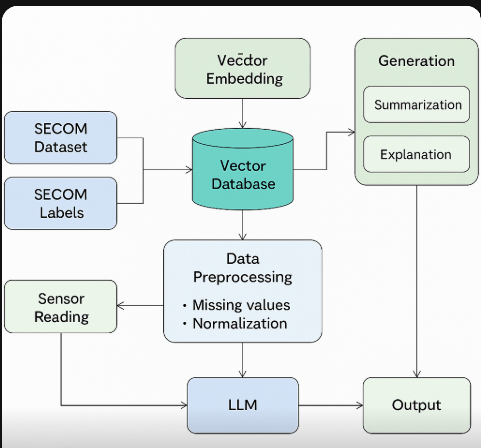

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
## prompt : Given the following sensor readings and the 5 most similar historical examples, summarize the differences and indicate if the current sample is likely faulty

## 1. load the datasets

In [ ]:
import pandas as pd

# data: 1576, features: 591
data = pd.read_csv("/content/drive/MyDrive/RAG Q&A System/semoconductor_data/data/secom/secom.data", delim_whitespace=True, header = None)

label_df = pd.read_csv("/content/drive/MyDrive/RAG Q&A System/semoconductor_data/data/secom/secom_labels.data", sep = ' ', header = None)



In [ ]:
print(data.shape)
print(label_df.shape)

In [ ]:
# changing the features for example 0 to feature_0
old_labels = list(data.columns)
type(old_labels)
new_labels = ["feature_"+str(i) for i in range(0,591)]
type(new_labels)
data.rename(columns=dict(zip(old_labels, new_labels)), inplace = True)

In [ ]:
x = list(i for i in range(0,5))
y = list(i for  i in range(5,9))
dc = dict(zip(x,y))
dc

In [ ]:
print(zip(x, y))

In [ ]:
# rename label data
label_df.rename(columns={0: "label", 1:"timestamp"}, inplace=True)

In [ ]:
label_df["label"].value_counts()
# 1 :  faulty
# -1 : not faulty

In [ ]:
label_df.sample(1)

In [ ]:
# createed 2 df, without preprocess, with preprocess
data_wo_preprocess = data.copy()
data_for_process = data.copy()
## handling nan value by imputing mean
data_for_process.fillna(data.mean(), inplace=True)
data_for_process.sample()

In [ ]:
print(data_wo_preprocess.isnull().values.any())
print(data_for_process.isnull().values.any())

#### scalling the data
- important if you're creating numerical embeddings using PCA, UMAP, or ML models before storing in the vector database.

In [ ]:
import numpy as np

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# scalling the data
# pre_scalled = data
scalled_data = scaler.fit_transform(data_for_process)
# print(scalled_data)
# convert to data frame
scalled_dataframe = pd.DataFrame(scalled_data, columns = data.columns, dtype=np.float32)
# scalled_dataframe = scalled_dataframe.round(4)

In [ ]:
# checkong if there is any index mismatching or not
(scalled_dataframe.index == label_df.index).all()

In [ ]:
scalled_dataframe.head()
# data_after_process = pd.concat([scalled_dataframe, label], axis = 1)

In [ ]:
# data_after_process.sample(2)

In [ ]:
## now will create prompt from scalled_dataframe and data_wo_preprocess
## label from label data

## prompt creation:
Sensor Log - Timestamp: [timestamp]

Original Sensor Readings:
[feature_1]: [raw_value_1], [feature_2]: [raw_value_2], ..., [feature_n]: [raw_value_n]

Processed Sensor Readings (NaNs filled, standardized):
[feature_1]: [scaled_value_1], [feature_2]: [scaled_value_2], ..., [feature_n]: [scaled_value_n]

System Status: [Faulty / Not Faulty]

In [ ]:
label_df.index

In [ ]:
# list_columns = list(data_wo_preprocess.columns)
# list_columns = list_columns[0:-2]

In [ ]:
#def create_prompt_column(data_wo_preprocess, scalled_dataframe, label_df)
prompts = []
labels = []
for i in range(0,1567):
  raw_data = ", ".join([f"{col}: {data_wo_preprocess.iloc[i][col]}" for col in data_wo_preprocess.columns])
  scaled_data = ", ".join([f"{col}: {scalled_dataframe.iloc[i][col]:.4f}" for col in scalled_dataframe.columns])
  label = "Faulty" if label_df.iloc[i]["label"] == 1 else "Not Faulty"
  timestamp = label_df.iloc[i]["timestamp"]

    # intro = ""
    # abstract = "Data is given from  a semi-conductor manufacturing process. "

    # intro_blurb = f"\n{intro}"
    # abstract_blurb = f"\n{abstract}"
    # prompt_intro =

  prompt = f""" You are a semiconductor sensor specialist. Below is a sensor log and system status. Analyze and summarize the key details. Asses the system status.Sensor Log - Timestamp: {timestamp}.Original Sensor Readings:{raw_data}.Processed Sensor Readings (Nan Filled wil mean value, standardizes):{scaled_data}.System Statue: {label}
  """
  # prompts[i] = prompt
  prompts.append(prompt)
  labels.append(label)

# return prompts

# print(raw_data)
# print(scaled_data)
# print(label)
# print(timestamp)
#prompts

In [ ]:
# print(scalled_dataframe.iloc[145])
# print(label_df.iloc[145])

In [ ]:
print(prompts[1566]) # 1 prompt with 24740 - 24750 tokens
print(labels[145])

In [ ]:
# prompts[1566]

In [ ]:
# !pip install langchain faiss-cpu langchain-community
from langchain.schema import Document

In [ ]:
# prompts = """This is my prompt"""
# label = "yes"
documents = [Document(page_content=prompt, metadata={"label":label}) for prompt, label in zip(prompts, labels)]

In [ ]:
# documents[0].page_content

In [ ]:
import locale

locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install -q langchain langchain-community

In [ ]:
## embedding- hugging-face embedding
# !pip install langchain-huggingface
from langchain_community.embeddings import HuggingFaceEmbeddings, OpenAIEmbeddings

embedding = HuggingFaceEmbeddings(model_name = "sentence-transformers/all-mpnet-base-v2")

##  creating vector db taking time, so decided to chunking:

1. scalled_df rounded to 4 folating point, during prompt creation.
2. tried with full prompt, but later when i will use llm it may not work because of the token limit.
3. trying to chunk the prompt... but it may lose some semantic meaning.
4. may PCA works , as i found out that only 204 features can get the 98% variance of the data.


In [ ]:
!pip install faiss-gpu-cu12

In [ ]:
# creating vector db taking time, so decided to chunking
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=30)

chunk_docs = splitter.split_documents(documents)

In [ ]:
len(chunk_docs)

In [ ]:
# chunk_text = [doc.page_content for doc in chunk_docs]

In [ ]:
# chunk_docs[0:2]

In [ ]:
## A vector store stores embedded data and performs similarity search.

## if takes time , should I chunk docs

from langchain_community.vectorstores import FAISS


In [ ]:
chunk_docs[0] # type : list

In [ ]:
#embedding = OpenAIEmbeddings()

In [ ]:
# converting the chunk doc into np_array
#embed_document() expect list of string not Document
texts = [doc.page_content for doc in chunk_docs] # type: list of text
text_embeddings = embedding.embed_documents(texts)# List of text to embed --> list of float
embeddings_np_text = np.array(text_embeddings, dtype = np.float32)
embeddings_np_text.shape # 768


In [ ]:
# type(texts)
# texts[0]


# vector store techniques
##### from_documents - without chunk/with chunk
##### from_embedding -
##### from_text -

In [ ]:
## error in from_embedding, now using from_texts
# https://python.langchain.com/api_reference/community/vectorstores/langchain_community.vectorstores.faiss.FAISS.html#langchain_community.vectorstores.faiss.FAISS.from_embeddings
faiss = FAISS.from_documents(chunk_docs, embedding)
# faiss = FAISS.from_texts(texts, embedding)

In [ ]:
# The zip() function returns a zip object, which is an iterator of tuples
# text_embedding_pairs = zip(texts, embeddings_np_text)
# # iterable [tuple[str, List[float]]]
# faiss = FAISS.from_embeddings(text_embedding_pairs, embedding) # embedding comming from model initialization
# ValueError: input not a numpy array

In [ ]:
# type(text_embedding_pairs)

In [ ]:
faiss

In [ ]:
# embeddings_chunk_docs = embedding.embed_documents(chunk_docs)
# embeddings_np_chunk_docs = np.array(embeddings_chunk_docs, dtype = np.float32)
# embeddings_np_chunk_docs.shape

In [ ]:
# embeddings = embedding.embed_documents(chunk_docs)
# embeddings_np = np.array(embeddings, dtype = np.float32)

In [ ]:
# db = FAISS.from_embeddings(text_embeddings=list(zip([doc.page_content for doc in chunk_docs], embeddings_np)), embedding=embedding)#
# db = FAISS.from_documents(chunk_docs, embeddings)

In [ ]:
# save in local
#/content/drive
faiss.save_local("/content/drive/MyDrive/RAG Q&A System/fiasis_doc_chunk_from_documents") # chunked doc
# load from local
# db = FAISS.load_local("fiasis_index_chunk", embedding)

In [ ]:
# We need a way to return(retrieve) the documents given an unstructured query. For that, we’ll use the as_retriever method
retriever = faiss.as_retriever(search_type = "similarity", search_kwargs ={"k": 4})

In [ ]:
!pip install --upgrade torch transformers accelerate bitsandbytes transformers sentence-transformers

In [ ]:
# load quantized model


import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import bitsandbytes

model_name = "HuggingFaceH4/zephyr-7b-beta"


In [ ]:
# need to upgrade bitsandbytes
!pip install -U bitsandbytes

In [ ]:
#
!pip install torchvision

In [ ]:
# bnb configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
# model initialization
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config = bnb_config)
# tokenizer initialization
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# setup the llm chain
# text_generation pipeline
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from transformers import pipeline
from langchain_core.output_parsers import StrOutputParser

text_generation_pipeline = pipeline(
    model = model,
    tokenizer = tokenizer,
    task = "text-generation",
    temperature = 0.6,
    do_sample = True,
    repetition_penalty = 1.1,
    return_full_text = True,
    max_new_tokens = 400,
)

llm = HuggingFacePipeline(pipeline = text_generation_pipeline)
# Next, create a prompt template - this should follow the format of the model, so if you substitute the model checkpoint, make sure to use the appropriate formatting.

prompt_template = """
<|system|>
Answer the question based on ypur knowledge. Use the following context to help:

{context}

</s>
<|user|>
{question}
</s>
<|assistant|>

"""

prompt = PromptTemplate(input_variables = ["context", "question"],
                        template = prompt_template)

llm_chain = prompt | llm | StrOutputParser ()

In [ ]:
# faiss = FAISS.load_local("/content/drive/MyDrive/RAG Q&A System/fiasis_doc_chunk_from_documents", embedding)

In [ ]:
from langchain_core.runnables import RunnablePassthrough

retriever = faiss.as_retriever()

rag_chain = {"context": retriever, "question": RunnablePassthrough()} | llm_chain

In [58]:
# “Were there any abnormal scaled readings before a Faulty event occurred?
# "How do sensor patterns differ between Faulty and Not Faulty logs?"
# "Summarize the system behavior and sensor anomalies for the logs labeled as Faulty."
# "What are the key sensor readings recorded around the most recent Faulty event?"
question_1 = "How do sensor patterns differ between Faulty and Not Faulty logs?"
question_2 = "Were there any abnormal scaled readings before a Faulty event occurred?"
question_3 = "Summarize the system behavior and sensor anomalies for the logs labeled as Faulty."
question_4 = "What are the key sensor readings recorded around the most recent Faulty event?"

## without specific context, llm can not answer the question

In [59]:
print(llm_chain.invoke({"context": "", "question": question_1}))

print("#"*100)

print(llm_chain.invoke({"context": "", "question": question_2}))

print("#"*100)

print(llm_chain.invoke({"context": "", "question": question_3}))

print("#"*100)

print(llm_chain.invoke({"context": "", "question": question_4}))


<|system|>
Answer the question based on ypur knowledge. Use the following context to help:



</s>
<|user|>
How do sensor patterns differ between Faulty and Not Faulty logs?
</s>
<|assistant|>

In the context provided, without any specific information about the sensors or the application being discussed, it is unclear how sensor patterns would differ between faulty and not faulty logs. However, in general, sensor patterns can vary significantly between faulty and non-faulty logs for various types of applications. For example, in industrial automation systems, faulty sensors may produce erratic readings or fail to record data altogether, resulting in abnormal sensor patterns. In contrast, healthy sensors will capture accurate and consistent measurements over time. By analyzing sensor patterns in logs, engineers and operators can identify potential equipment malfunctions, predict maintenance needs, and optimize system performance.
########################################################

## with specific data provided in the rag chain. It atleast understand the context of the question. Moreover the data is imbalanced.

- total data 1567
 - 104 label_1
 - 1463 label_2

In [60]:
print(rag_chain.invoke(question_1))

print("#"*100)

print(rag_chain.invoke(question_2))

print("#"*100)

print(rag_chain.invoke(question_3))

print("#"*100)

print(rag_chain.invoke(question_4))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



<|system|>
Answer the question based on ypur knowledge. Use the following context to help:

[Document(id='964a10b1-0095-4077-95b6-1cec0331d78f', metadata={'label': 'Not Faulty'}, page_content='You are a semiconductor sensor specialist. Below is a sensor log and system status. Analyze and summarize the key details. Asses the system status.Sensor Log - Timestamp: 19/09/2008 20:05:00.Original Sensor Readings:feature_0: 2964.63, feature_1: 2494.75, feature_2: nan, feature_3: nan, feature_4: nan, feature_5: nan, feature_6: nan, feature_7: nan, feature_8: 1.4646, feature_9: 0.0021, feature_10: 0.0059, feature_11: 0.9759, feature_12: 201.8533, feature_13: 0.0, feature_14: 9.2058, feature_15: 404.0754,'), Document(id='dd9fe24f-f210-46de-98e7-795d2fc9af6c', metadata={'label': 'Not Faulty'}, page_content='You are a semiconductor sensor specialist. Below is a sensor log and system status. Analyze and summarize the key details. Asses the system status.Sensor Log - Timestamp: 17/10/2008 05:26:00.O

### 2. Embedding or dimensionality reduction
 - without embedding, vector similarity search will be impossible. Which is core part of RAG

In [ ]:
!pip install numpy scikit-learn

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# before applying pca
pca = PCA().fit(scalled_dataframe)
comulative_var = pca.explained_variance_ratio_.cumsum()

threshold = 0.98
val = np.where(comulative_var >= threshold)[0][0]+1
val

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

In [ ]:
# apply pca
n_components = 204
best_pca = PCA(n_components = n_components)
embeddings = best_pca.fit_transform(scalled_dataframe)

In [ ]:
scalled_dataframe.iloc[0]

In [ ]:
embeddings[0]

In [ ]:
embeddings.shape

In [ ]:
from langchain.schema import Document
from langchain.vectorstores import FAISS
from langchain.embeddings.base import Embeddings

In [ ]:
# class embed(embeddings):
#   def __init__(self, vector):
#     self.vector = vector
#   def embed_documents(self, text):
#     return self.vector
#   def embed_query(self, text):
#     return self

Now what have I done? I have done this:
scaled_data_label_for_doc = pd.concat([scalled_dataframe, label], axis = 1)
where scaled dataframe shape is 1567 by 590
and embedding is np array and shape is (1567, 204)

So my question is, scaled label data has more features than embeddings, so will it be problematic for similarity search if I pass the scaled data (1567 by 590) with label inot document and embedding as embedding data, which has shape: (1567, 204) . can you give me answer in short and precious

In [ ]:
# for creating doc, i will first marge the scaled_datafraem and label, then convert it inot the document. I have embedding of the features, which was done by pca. I will pass that embedding
scaled_data_label_for_doc = pd.concat([scalled_dataframe, label], axis = 1)
# drop column timestamp
scaled_data_label_for_doc.drop(columns = ['timestamp'], inplace = True)

In [ ]:
embeddings.shape

In [ ]:
documents = [
    Document(
        page_content="Sensor reading data after StandardScaling " + str(i) + ":" + str(row[1].drop("label").values.tolist()),
        metadata={"label": int(row[1]["label"])}
    )

    for i, row in enumerate(scaled_data_label_for_doc.iterrows())
]



In [ ]:
# documents[0]

In [ ]:
# for i, row in enumerate(scaled_data_label_for_doc.iterrows()):
#   if i <= 2:
#     # print(row)
#     print(row[1]["label"])
type(embeddings)

In [ ]:
# created documents from the scaled data and label
documents[0]

### 3. Vector db

In [ ]:
# embeddings[0]
# Dummy class to bypass LangChain's Embeddings interface
class DummyEmbeddings(Embeddings):
    def __init__(self, vectors):
        self.vectors = vectors
    def embed_documents(self, texts):
        return self.vectors
    def embed_query(self, text):
        return self.vectors[0]  # Just an example

In [ ]:
dummy_embeddings = DummyEmbeddings(embeddings)

In [ ]:
dummy_embeddings

In [ ]:
db = FAISS(embedding_function= DummyEmbeddings(embeddings))

### 4. LLM

### 5. RAG framework